In [37]:
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.stderr = open(os.devnull, 'w')  
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

dataset_path = '/kaggle/input/skyview-an-aerial-landscape-dataset/Aerial_Landscapes'

def load_and_split_by_class(dataset_path, image_size=(224, 224), train_ratio=0.8):
    X_train, y_train, X_test, y_test = [], [], [], []

    for label in sorted(os.listdir(dataset_path)):
        class_dir = os.path.join(dataset_path, label)
        if not os.path.isdir(class_dir):
            continue
        files = sorted(os.listdir(class_dir))
        images = []
        failed = 0
        for file_name in files:
            file_path = os.path.join(class_dir, file_name)
            img = cv2.imread(file_path)
            if img is None:
                failed += 1
                continue
            img = cv2.resize(img, image_size)
            images.append(img)

        print(f" Class '{label}': {len(images)} images loaded, {failed} failed")
        images = shuffle(images, random_state=42)
        split_idx = int(len(images) * train_ratio)
        X_train.extend(images[:split_idx])
        y_train.extend([label] * split_idx)
        X_test.extend(images[split_idx:])
        y_test.extend([label] * (len(images) - split_idx))

    return shuffle(np.array(X_train), np.array(y_train), random_state=42), \
           shuffle(np.array(X_test), np.array(y_test), random_state=42)

(X_train, y_train), (X_test, y_test) = load_and_split_by_class(dataset_path)

le = LabelEncoder()
y_train_enc = to_categorical(le.fit_transform(y_train))
y_test_enc = to_categorical(le.transform(y_test))
class_names = le.classes_.tolist()

print("Each class split 80/20 successfully. Classes:", class_names)


 Class 'Agriculture': 800 images loaded, 0 failed
 Class 'Airport': 800 images loaded, 0 failed
 Class 'Beach': 800 images loaded, 0 failed
 Class 'City': 800 images loaded, 0 failed
 Class 'Desert': 800 images loaded, 0 failed
 Class 'Forest': 800 images loaded, 0 failed
 Class 'Grassland': 800 images loaded, 0 failed
 Class 'Highway': 800 images loaded, 0 failed
 Class 'Lake': 800 images loaded, 0 failed
 Class 'Mountain': 800 images loaded, 0 failed
 Class 'Parking': 800 images loaded, 0 failed
 Class 'Port': 800 images loaded, 0 failed
 Class 'Railway': 800 images loaded, 0 failed
 Class 'Residential': 800 images loaded, 0 failed
 Class 'River': 800 images loaded, 0 failed
Each class split 80/20 successfully. Classes: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.15,
                               width_shift_range=0.1, height_shift_range=0.1,
                               horizontal_flip=True)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow(X_train, y_train_enc, batch_size=32)
test_data = test_gen.flow(X_test, y_test_enc, batch_size=32, shuffle=False)

In [8]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Multiply, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Contains SE module EfficientNet
def build_efficientnet_with_se(input_shape, num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    # SE module
    channels = x.shape[-1]
    se = GlobalAveragePooling2D()(x)
    se = Reshape((1, 1, channels))(se)
    se = Dense(channels // 16, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    x = Multiply()([x, se])
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=output)

# Does not contain SE module EfficientNet
def build_efficientnet_baseline(input_shape, num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=output)

# Training function: Output consistent with Keras default format
def train_and_evaluate(model, name, train_data, test_data, epochs=30):
    print(f"\nTraining {name}")
    for layer in model.layers:
        layer.trainable = True

    model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)
    ]

    history = model.fit(train_data,
                        validation_data=test_data,
                        epochs=epochs,
                        callbacks=callbacks,
                        verbose=1)
    return model, history


In [9]:
# Obtain real labels
y_test_labels = np.argmax(y_test_enc, axis=1)

# Training with SE module EfficientNet
model_with_se = build_efficientnet_with_se((224, 224, 3), y_train_enc.shape[1])
model_with_se, hist_with_se = train_and_evaluate(model_with_se, "EfficientNet + SE", train_data, test_data)


Training EfficientNet + SE
Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 191s 322ms/step - accuracy: 0.0895 - loss: 2.7039 - val_accuracy: 0.0879 - val_loss: 2.7054 - learning_rate: 1.0000e-05
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 92s 299ms/step - accuracy: 0.2299 - loss: 2.4998 - val_accuracy: 0.2446 - val_loss: 2.5833 - learning_rate: 1.0000e-05
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 92s 299ms/step - accuracy: 0.4346 - loss: 2.1735 - val_accuracy: 0.6508 - val_loss: 1.9027 - learning_rate: 1.0000e-05
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 92s 299ms/step - accuracy: 0.6087 - loss: 1.7750 - val_accuracy: 0.8125 - val_loss: 1.3061 - learning_rate: 1.0000e-05
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 92s 299ms/step - accuracy: 0.7274 - loss: 1.3388 - val_accuracy: 0.8625 - val_loss: 0.8108 - learning_rate: 1.0000e-05
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 92s 299ms/step - accuracy: 0.8005 - loss: 0.9363 - val_accuracy: 0.8992 - val_loss: 0.4877 - learning_rate: 1.0000e-05
Epoch 7/30
300/30

In [10]:
# Obtain real labels
y_test_labels = np.argmax(y_test_enc, axis=1)


# Training baseline without SE module EfficientNet
model_baseline = build_efficientnet_baseline((224, 224, 3), y_train_enc.shape[1])
model_baseline, hist_baseline = train_and_evaluate(model_baseline, "EfficientNet Baseline", train_data, test_data)


Training EfficientNet Baseline
Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 183s 327ms/step - accuracy: 0.0918 - loss: 2.7805 - val_accuracy: 0.0825 - val_loss: 2.6996 - learning_rate: 1.0000e-05
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 92s 298ms/step - accuracy: 0.2390 - loss: 2.4066 - val_accuracy: 0.2233 - val_loss: 2.5342 - learning_rate: 1.0000e-05
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 91s 297ms/step - accuracy: 0.4366 - loss: 1.9765 - val_accuracy: 0.6496 - val_loss: 1.6161 - learning_rate: 1.0000e-05
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 92s 299ms/step - accuracy: 0.5482 - loss: 1.6180 - val_accuracy: 0.7758 - val_loss: 1.1100 - learning_rate: 1.0000e-05
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 91s 297ms/step - accuracy: 0.6561 - loss: 1.2751 - val_accuracy: 0.8375 - val_loss: 0.7984 - learning_rate: 1.0000e-05
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 92s 298ms/step - accuracy: 0.7468 - loss: 0.9618 - val_accuracy: 0.8829 - val_loss: 0.5617 - learning_rate: 1.0000e-05
Epoch 7/30
30

In [17]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Predict and convert to class labels
y_pred_with_se = model_with_se.predict(test_data)
y_pred_labels_with_se = np.argmax(y_pred_with_se, axis=1)

y_pred_baseline = model_baseline.predict(test_data)
y_pred_labels_baseline = np.argmax(y_pred_baseline, axis=1)

# Obtain real labels
y_true_labels = np.argmax(y_test_enc, axis=1)

# Print classification report function
def print_report(y_true, y_pred, title=""):
    print(f"=== Evaluation Results for {title} ===")
    acc = accuracy_score(y_true, y_pred)
    macro_precision = precision_score(y_true, y_pred, average='macro')
    macro_recall = recall_score(y_true, y_pred, average='macro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_recall = recall_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (Macro): {macro_precision:.4f}")
    print(f"F1-Score (Macro): {macro_f1:.4f}")
    print(f"Weighted Recall: {weighted_recall:.4f}")
    print(f"Macro Recall: {macro_recall:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=2))

# Print the evaluation results of the EfficientNet + SE model
print_report(y_true_labels, y_pred_labels_with_se, title="EfficientNet + SE")

# Print the evaluation results of the EfficientNet Baseline model
print_report(y_true_labels, y_pred_labels_baseline, title="EfficientNet Baseline")


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
=== Evaluation Results for EfficientNet + SE ===
Accuracy: 0.9742
Precision (Macro): 0.9745
F1-Score (Macro): 0.9741
Weighted Recall: 0.9742
Macro Recall: 0.9742

Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.95      1.00      0.97       160
     Airport       0.96      0.97      0.97       160
       Beach       0.97      0.99      0.98       160
        City       0.97      0.97      0.97       160
      Desert       0.98      0.95      0.97       160
      Forest       0.99      0.99      0.99       160
   Grassland       1.00      0.95      0.97       160
     Highway       0.96      1.00      0.98       160
        Lake       0.99      0.95      0.97       160
    Mountain       0.96      0.98      0.97       160
     Parking       0.99      0.99      0.99       160
        Port       0.98      0.96      0.97       160
     Railway       0.97      0.

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


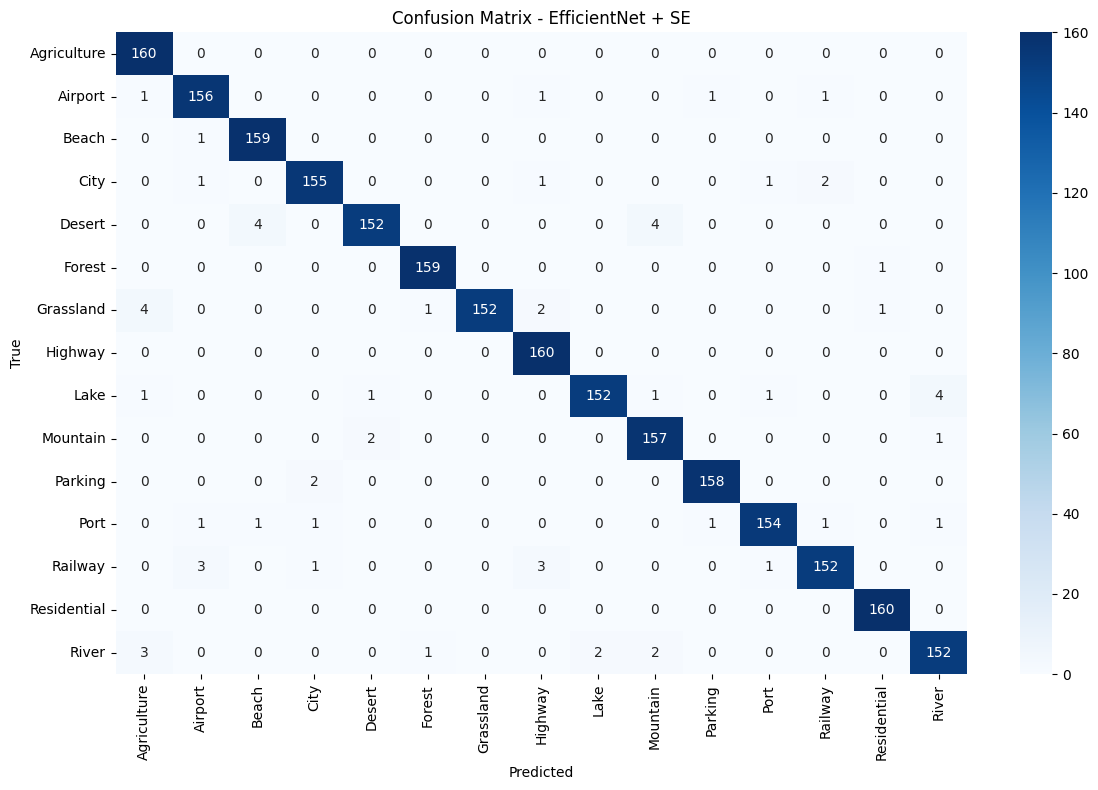

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict test_data and extract prediction labels 
y_pred_se = np.argmax(model_with_se.predict(test_data), axis=1)
y_true = np.argmax(y_test_enc, axis=1)

# Constructing a confusion matrix
cm_se = confusion_matrix(y_true, y_pred_se)

# Drawing
plt.figure(figsize=(12, 8))
sns.heatmap(cm_se, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - EfficientNet + SE")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()



75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


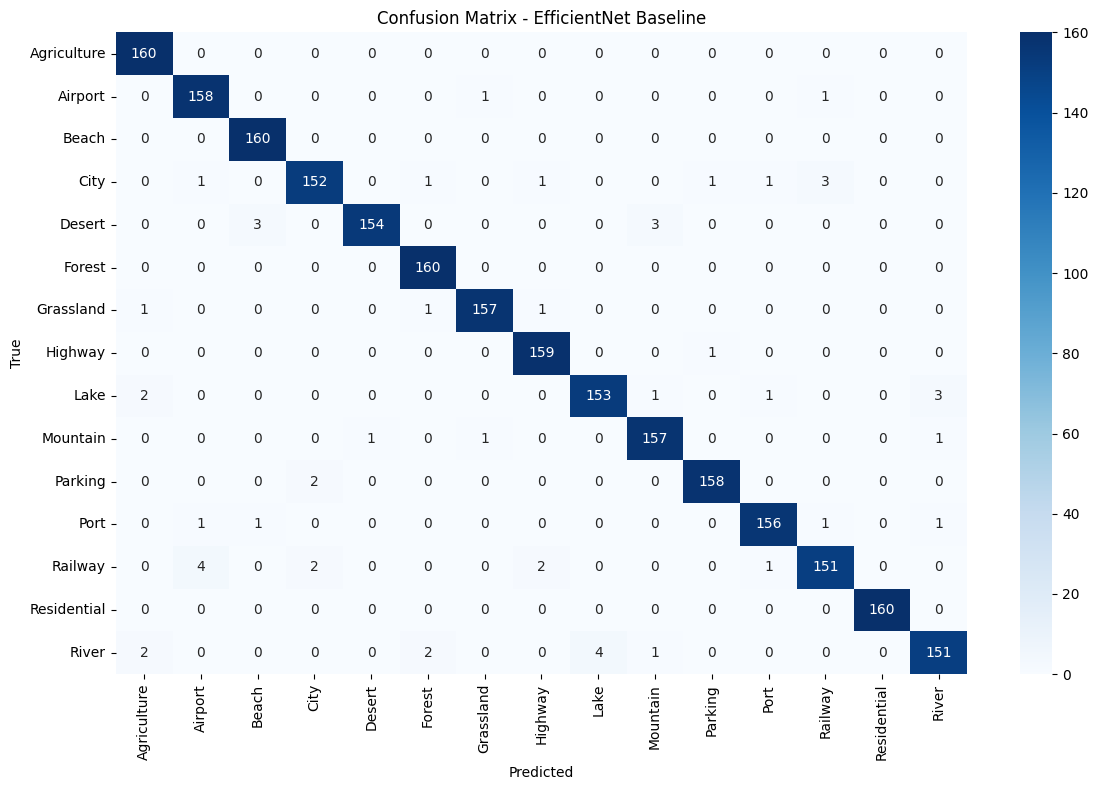

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict test_data and extract prediction labels 
y_pred_baseline = np.argmax(model_baseline.predict(test_data), axis=1)
y_true = np.argmax(y_test_enc, axis=1)

# Constructing a confusion matrix
cm_baseline = confusion_matrix(y_true, y_pred_baseline)

# Drawing
plt.figure(figsize=(12, 8))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - EfficientNet Baseline")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [25]:
def display_predictions(images, true_labels, pred_labels, class_names, num_samples=5, title="Predictions"):
    fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(15, 3))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            ax.set_title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}", fontsize=9)
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.75)  
    plt.show()


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


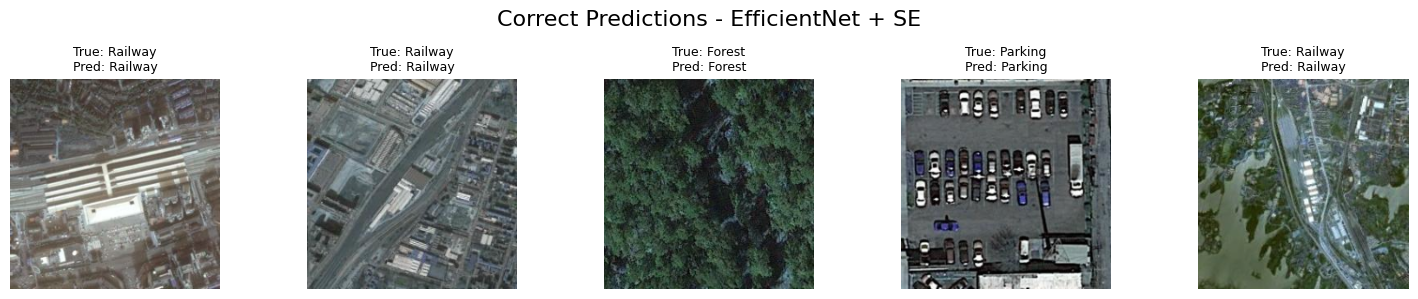

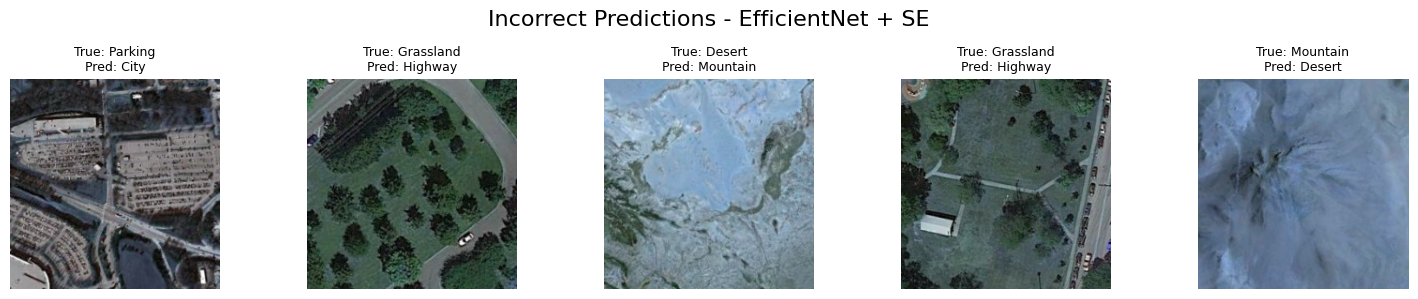

In [36]:
# EfficientNet + SE model prediction
y_pred_se = np.argmax(model_with_se.predict(test_data), axis=1)
y_true = np.argmax(y_test_enc, axis=1)

# Get the indexes of correct and incorrect predictions
correct_indices_se = np.where(y_true == y_pred_se)[0][:5]
incorrect_indices_se = np.where(y_true != y_pred_se)[0][:5]

# Show correct predictions
display_predictions(X_test[correct_indices_se], y_true[correct_indices_se], y_pred_se[correct_indices_se], class_names, num_samples=5, title="Correct Predictions - EfficientNet + SE")

# Display error predictions
display_predictions(X_test[incorrect_indices_se], y_true[incorrect_indices_se], y_pred_se[incorrect_indices_se], class_names, num_samples=5, title="Incorrect Predictions - EfficientNet + SE")


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


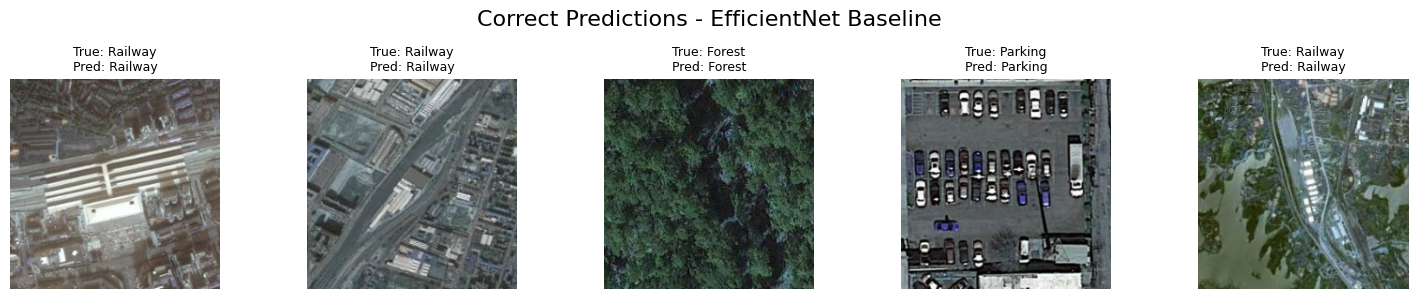

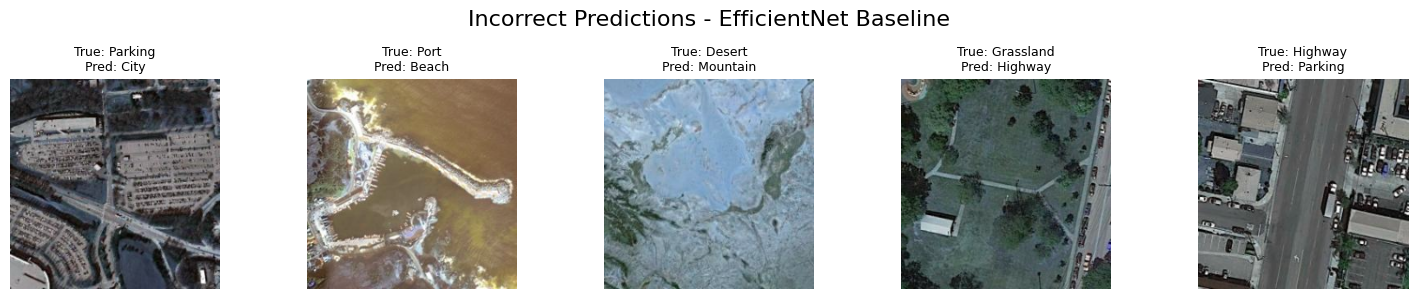

In [35]:
# EfficientNet Baseline Model Prediction
y_pred_baseline = np.argmax(model_baseline.predict(test_data), axis=1)

# Get the indexes of correct and incorrect predictions
correct_indices_base = np.where(y_true == y_pred_baseline)[0][:5]
incorrect_indices_base = np.where(y_true != y_pred_baseline)[0][:5]

# Show correct predictions
display_predictions(X_test[correct_indices_base], y_true[correct_indices_base], y_pred_baseline[correct_indices_base], class_names, num_samples=5, title="Correct Predictions - EfficientNet Baseline")

# Display error predictions
display_predictions(X_test[incorrect_indices_base], y_true[incorrect_indices_base], y_pred_baseline[incorrect_indices_base], class_names, num_samples=5, title="Incorrect Predictions - EfficientNet Baseline")
